##  Imports

In [1]:
import os
import sys
import time
from datetime import datetime

import numpy as np
import cv2
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torch.utils.tensorboard import SummaryWriter

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from sklearn.model_selection import train_test_split, KFold

from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# from torchmetrics import F1, Accuracy
# import timm

In [3]:
from data_handler.FaceMaskData import FaceMaskData
from data_handler.FaceMaskDataset import FaceMaskDataset

In [4]:
# %load_ext tensorboard 

In [5]:
assert torch.cuda.is_available()

## Configurations

In [6]:
class CFG:
    seed = 42
    model_name = 'faster_rcnn'
    pretrained = True
    img_width = 480
    img_height = 480
    batch_size = 10
    n_epochs = 100
    n_folds = 5
    drop_rate = 0.
    train_size = 0.85
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    num_workers=4
    num_classes=4

np.random.seed(CFG.seed)

## Data Load

Define transformations

In [7]:
train_transforms = A.Compose([
            ToTensorV2(p=1.0) 
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

valid_transforms = A.Compose([
            ToTensorV2(p=1.0)
], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

Load the data into a dataset

In [8]:
imgs_path = 'images'        #   images dir
msks_path = 'annotations'   #   annotations dir

faceMasksData = FaceMaskData(imgs_path, msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data(drop_rate=CFG.drop_rate)

trainset = FaceMaskDataset(x_train, y_train, imgs_path, msks_path, CFG.img_width, CFG.img_height, transforms=train_transforms)
validset = FaceMaskDataset(x_test, y_test, imgs_path, msks_path, CFG.img_width, CFG.img_height, transforms=valid_transforms)

print('Training contains {} samples which is {:g}% of the data'.format(len(trainset), len(trainset) * 100 / (len(trainset) + len(validset))))
print('Validation contains {} samples which is {:g}% of the data'.format(len(validset), len(validset) * 100 / (len(trainset) + len(validset))))

-- The data loaded using drop_rate=0.95, therefore not all of the data will be loaded! --
Training contains 33 samples which is 78.5714% of the data
Validation contains 9 samples which is 21.4286% of the data


Define collate function for PyTorch's Dataloader, as the data shape is not consistant

In [9]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [10]:
train_loader = DataLoader(dataset=trainset, batch_size=CFG.batch_size, shuffle=True, num_workers=CFG.num_workers, collate_fn=collate_fn)
valid_loader = DataLoader(dataset=validset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, collate_fn=collate_fn)

In [11]:
dataloaders = { 'train': train_loader,
                'valid': valid_loader }

## Train Examples

In [12]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def get_annotated_img(img, annt):
    img = np.array(np.transpose(img, (1, 2, 0))) * 255.0    #   multiple by 255 as in the dataset we divide it
                                                                #   needed here because the image come from the dataset in values of [0, 1]
                                                                #   and the annotations are in values of [0, 255] and plt should get images
                                                                #   with values of [0, 1], therefore a normalizing of the images is needed
        
    for box, cat in zip(annt['boxes'], annt['labels']):
        xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
        color = (0, 0, 0)
        if cat == 0:
            color = (0, 255, 0)
        elif cat == 1:
            color = (0, 0, 255)
        elif cat == 2:
            color = (255, 0, 0)
        thickness = 1
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1 / 3
        img = cv2.putText(img, '{} ({})'.format(validset.classes[cat], int(cat)), start_point, font, fontScale, color, thickness, cv2.LINE_AA)
    
    return img

def show_augmented_samples(dataloader, model=None):
    plt.figure(figsize=(10, 80))
    
    samples, annotations = next(iter(dataloader))   #   get the first batch

    amount_samples = min(12, len(samples))          #   number of examples will be at most 12

    for i, (img, ant) in enumerate(zip(samples, annotations)):
        if i >= amount_samples:
            break

        plt.subplot(amount_samples, 1, i + 1)
        plt.axis('off')
        
        img = get_annotated_img(img, ant)
        
        plt.imshow(norm(img))  
    plt.tight_layout()
    plt.show()

# show_augmented_samples(dataloaders['train'])

## Training

In [13]:
def get_writers(path):
    writer_train_epoch = SummaryWriter('{}/logs/{}_train'.format(path, CFG.model_name))
    writer_valid_epoch = SummaryWriter('{}/logs/{}_valid'.format(path, CFG.model_name))

    return {    'train': writer_train_epoch,
                'valid': writer_valid_epoch }

In [14]:
def create_env(path):
    if not os.path.exists(path):
        os.mkdir(path)
    paths = ['logs', 'models']
    for p in paths:
        sub_path = os.path.join(path, p)
        if not os.path.exists(sub_path):
            os.mkdir(sub_path)

In [15]:
def train(model, loaders, optimizer, epochs, path, scheduler=None):
    print('This running path is: `{}`\n'.format(path))
    time.sleep(1)
    create_env(path)
    writers = get_writers(path)

    device = CFG.device
    model = model.to(device).train()

    best_loss = 10000

    for epch in range(1, epochs + 1):              #   iterate epoch
        print('Epoch {:3d} of {}:'.format(epch, epochs), flush=True)
             
        epoch_print = ''
        for phase in ['train', 'valid']:    #   iterate phases

            with tqdm(total=len(loaders[phase]), desc=phase) as progress_bar:               #   define progress bas
                samples = 0
                epoch_losses = dict()
                accum_loss = 0.0

                for imgs, annts in loaders[phase]:                                     #   iterate batches
                    imgs  = list(img.to(device) for img in imgs)
                    
                    annts = [{k: v.to(device) for k, v in t.items()} for t in annts]

                    batch_size = len(imgs)
                    samples += batch_size

                    if phase == 'train':
                        loss_dict = model(imgs, annts)                          #   calculate batch losses
                    else:
                        with torch.no_grad():
                            loss_dict = model(imgs, annts) 

                    losses = sum(loss for loss in loss_dict.values())       #   sum total of all batch loseses
                    if phase == 'train':
                        optimizer.zero_grad()
                        losses.backward()
                        optimizer.step()

                    accum_loss += losses.item()                             #   add to get epoch loss at the end
                    #   accumulate losses to get final loss of epoch
                    for name, val in loss_dict.items():
                        if name in epoch_losses:
                            epoch_losses[name] += val / batch_size
                        else:
                            epoch_losses[name] = val / batch_size

                    del imgs, annts, loss_dict, losses
                    torch.cuda.empty_cache()
                    progress_bar.update(1)

            accum_loss /= samples

            epoch_print += phase + ':\t'
            for key, val in epoch_losses.items():
                writers[phase].add_scalar(key, val, epch)
                epoch_print += '{}={:.5f}\t'.format(key, val)
            epoch_print += 'total loss={:.5f}\n'.format(accum_loss)
            writers[phase].add_scalar('average_loss', accum_loss, epch)

            del epoch_losses

        print(epoch_print, flush=True)
        
        if scheduler is not None:
            writers['train'].add_scalar('lr_epoch', scheduler.get_last_lr()[0], epch)
            scheduler.step()

        saveing_path = '{}/models/{}_epoch_{}.pth'.format(path, CFG.model_name, epch)
        torch.save(model.state_dict(), saveing_path)     
        
        # if the model perform better in this epoch, save it's parameters
        if accum_loss < best_loss:
            best_loss = accum_loss
            saveing_path = '{}/models/{}_best.pth'.format(path, CFG.model_name)
            torch.save(model.state_dict(), saveing_path)

In [16]:
def get_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #   get model
    in_features = model.roi_heads.box_predictor.cls_score.in_features                   #   get input size of last layer
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)         #   regenerate the last layer
    return model

In [17]:
model = get_model(num_classes=CFG.num_classes, pretrained=CFG.pretrained)

In [18]:
params = [p for p in model.parameters() if p.requires_grad]         #   get optimizeable paramaters
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [19]:
datetime_srt = datetime.today().strftime("%d-%m-%y_%H:%M")
run_path = os.path.join(sys.path[0], 'runs', datetime_srt)

TODO: accumulate each loss separetly

In [20]:
train(model, dataloaders, optimizer, CFG.n_epochs, run_path, scheduler)

This running path is: `/home/linuxgpu/anaconda3/envs/lab_1/files/runs/22-10-21_19:09`

Epoch   1 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

train:	loss_classifier=0.39913	loss_box_reg=0.15175	loss_objectness=0.06548	loss_rpn_box_reg=0.01440	total loss=0.13599
valid:	loss_classifier=0.06015	loss_box_reg=0.03549	loss_objectness=0.00996	loss_rpn_box_reg=0.00290	total loss=0.10851



Epoch   2 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]

train:	loss_classifier=0.26097	loss_box_reg=0.16251	loss_objectness=0.02827	loss_rpn_box_reg=0.00939	total loss=0.10445
valid:	loss_classifier=0.05987	loss_box_reg=0.03761	loss_objectness=0.00770	loss_rpn_box_reg=0.00285	total loss=0.10802



Epoch   3 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

train:	loss_classifier=0.25183	loss_box_reg=0.16078	loss_objectness=0.02947	loss_rpn_box_reg=0.00859	total loss=0.10291
valid:	loss_classifier=0.05912	loss_box_reg=0.03785	loss_objectness=0.00690	loss_rpn_box_reg=0.00284	total loss=0.10671



Epoch   4 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

train:	loss_classifier=0.21241	loss_box_reg=0.14113	loss_objectness=0.02897	loss_rpn_box_reg=0.00859	total loss=0.09835
valid:	loss_classifier=0.05896	loss_box_reg=0.03781	loss_objectness=0.00759	loss_rpn_box_reg=0.00284	total loss=0.10721



Epoch   5 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.08s/it]

train:	loss_classifier=0.46275	loss_box_reg=0.31062	loss_objectness=0.06161	loss_rpn_box_reg=0.02921	total loss=0.13039
valid:	loss_classifier=0.05895	loss_box_reg=0.03781	loss_objectness=0.00571	loss_rpn_box_reg=0.00284	total loss=0.10532



Epoch   6 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.13s/it]

train:	loss_classifier=0.23510	loss_box_reg=0.15104	loss_objectness=0.03209	loss_rpn_box_reg=0.00794	total loss=0.10038
valid:	loss_classifier=0.05894	loss_box_reg=0.03781	loss_objectness=0.00722	loss_rpn_box_reg=0.00284	total loss=0.10682



Epoch   7 of 20:


valid: 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

train:	loss_classifier=0.29761	loss_box_reg=0.20298	loss_objectness=0.03474	loss_rpn_box_reg=0.00836	total loss=0.10833
valid:	loss_classifier=0.05897	loss_box_reg=0.03781	loss_objectness=0.00959	loss_rpn_box_reg=0.00284	total loss=0.10922



Epoch   8 of 20:


valid: 100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

train:	loss_classifier=0.41133	loss_box_reg=0.27777	loss_objectness=0.05471	loss_rpn_box_reg=0.02506	total loss=0.12413
valid:	loss_classifier=0.05897	loss_box_reg=0.03781	loss_objectness=0.00853	loss_rpn_box_reg=0.00284	total loss=0.10816



Epoch   9 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.07s/it]

train:	loss_classifier=0.45309	loss_box_reg=0.29762	loss_objectness=0.05403	loss_rpn_box_reg=0.02083	total loss=0.12833
valid:	loss_classifier=0.05897	loss_box_reg=0.03781	loss_objectness=0.00752	loss_rpn_box_reg=0.00284	total loss=0.10714



Epoch  10 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

train:	loss_classifier=0.33804	loss_box_reg=0.23135	loss_objectness=0.04905	loss_rpn_box_reg=0.01515	total loss=0.11536
valid:	loss_classifier=0.05895	loss_box_reg=0.03781	loss_objectness=0.00574	loss_rpn_box_reg=0.00284	total loss=0.10535



Epoch  11 of 20:


valid: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it]

train:	loss_classifier=0.26530	loss_box_reg=0.17317	loss_objectness=0.04473	loss_rpn_box_reg=0.00856	total loss=0.10515
valid:	loss_classifier=0.05896	loss_box_reg=0.03781	loss_objectness=0.00712	loss_rpn_box_reg=0.00284	total loss=0.10674



Epoch  12 of 20:


train:  50%|█████     | 2/4 [00:05<00:05,  2.57s/it]


KeyboardInterrupt: 

In [29]:
def plot_test_examples(model, loader):
    device = CFG.device
    model = model.to(device).eval()

    imgs, annts = next(iter(loader))
    imgs  = list(img.to(device) for img in imgs)

    output = model(imgs)

    amount_samples = min(12, len(imgs))          #   number of examples will be at most 12
    fig, axes = plt.subplots(nrows=amount_samples, ncols=2, figsize=(14, 60))

    axes[0][0].set_title('Ground Truth')
    axes[0][1].set_title('Prediction')

    
    for i, (img, ant, pred) in enumerate(zip(imgs, annts, output)):
        if i >= amount_samples:
            break

        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

        annot_img = get_annotated_img(img.cpu(), ant)
        axes[i, 0].imshow(norm(annot_img))          

        pred_cpu = {k: v.cpu() for k, v in pred.items()}
        # [{k: v.to(device) for k, v in t.items()} for t in annts]

        annot_img = get_annotated_img(img.cpu(), pred_cpu)
        axes[i, 1].imshow(norm(annot_img))  

    fig.tight_layout()
    plt.show()

    del imgs
    torch.cuda.empty_cache()

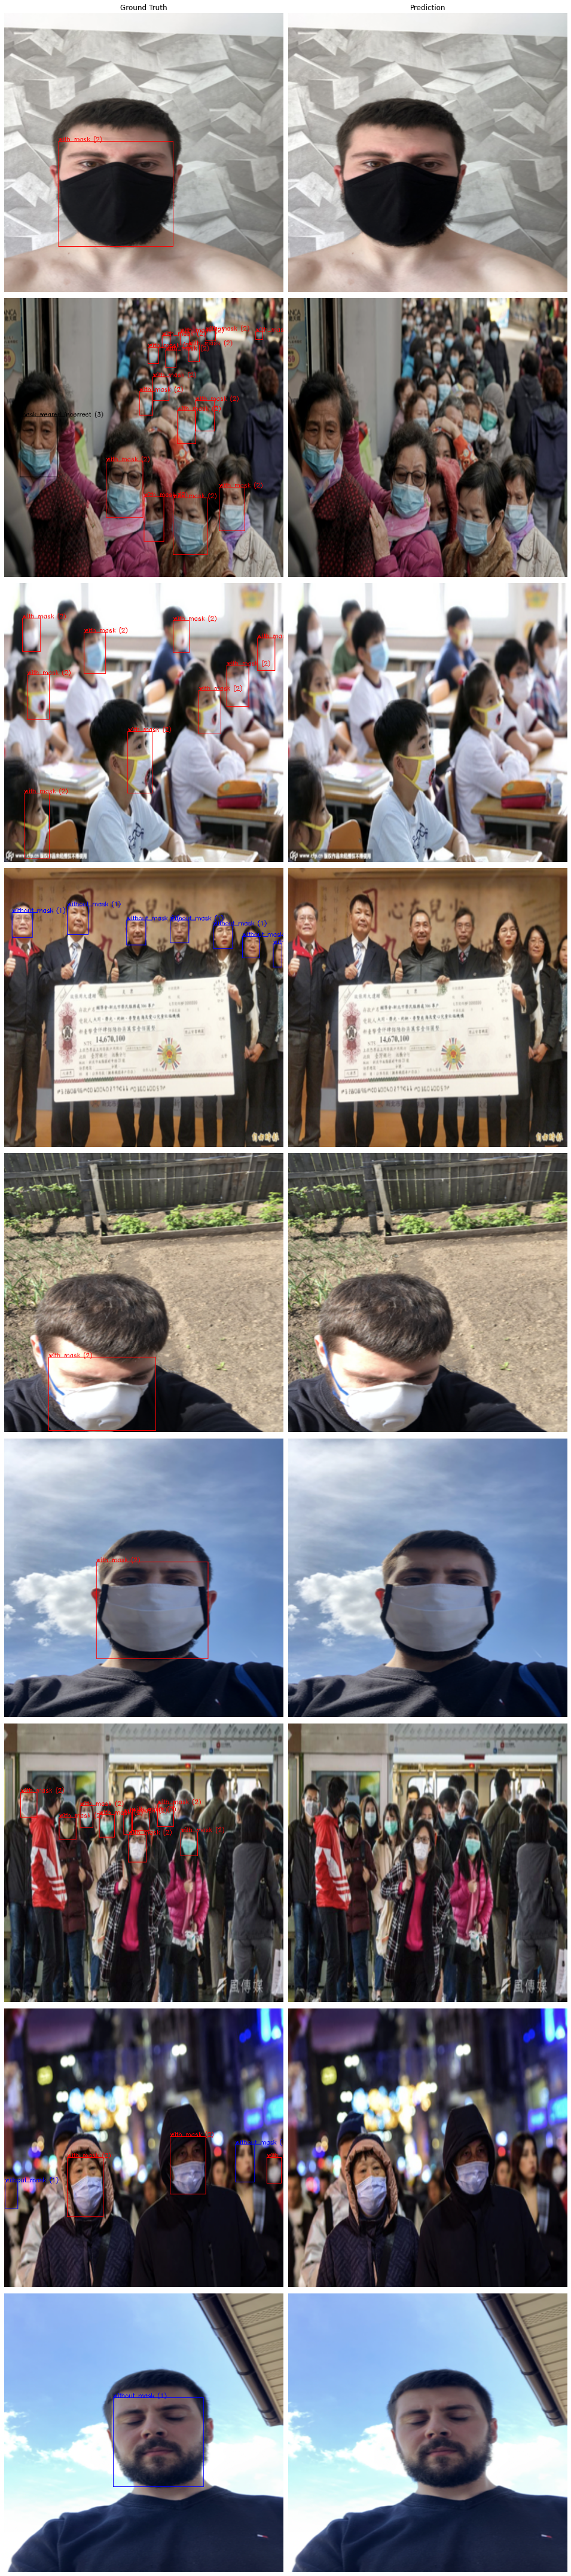

In [30]:
plot_test_examples(model, dataloaders['valid'])